###### CC2006 - Inteligência Artificial

# Connect4 

_Criação de um jogo Connect Four usando algoritmos de Inteligência Artificial: A*, Alpha-Beta Pruning e Monte Carlo Tree Search)_

_O código completo (com execução pelo Pygame) está armazenado no seguinte repositório do GitHub: https://github.com/RobertGleison/connect4.git_




### _Integrantes:_
   
_Robert Gleison dos Reis Pereira (up202200496)_  
_Sophia Cheto de Queiroz Fonseca (up202200496)_    
_Guilherme .. (up202200496)_  

---


## Introdução

#### Sobre o jogo:
Connect 4, também conhecido como Quatro em Linha, é um jogo de estratégia para dois jogadores. O objetivo é ser o primeiro a alinhar quatro peças da mesma cor consecutivamente, seja na vertical, horizontal ou diagonal, em um tabuleiro vertical com sete colunas e seis linhas. Os jogadores alternam colocando suas peças em uma coluna vazia, tentando bloquear o adversário enquanto procuram formar sua própria sequência de quatro peças.

#### O nosso projeto:

O jogo foi desenvolvido em Python, usando a biblioteca numpy como auxílio para as matrizes que representam o tabuleiro. Para a interface gráfica, utilizamos o Pygame para criar uma melhor interação com o usuário.  
Há dois modos de jogo: "Player vs Player", para dois jogadores, e "Single Player", onde o jogador joga contra o computador. No segundo modo, foram implementados os seguintes algoritmos, com suas respectivas identificações na interface do Pygame:
* A* _(fácil)_
* A* Adversarial _(médio)_
* Alpha-Beta Pruning _(difícil)_
* Monte Carlo Tree Search _(desafio)_  


#### Considerações:
Para a apresentação do código neste notebook, optamos por retirar a integração com o Pygame, gerando um código mais limpo e mais fácil de compreender pela leitura. Assim, aqui temos apenas o programa lógico e algorítimico do jogo. O código completo está disponível no GitHub.




---

# Estrutura do projeto:
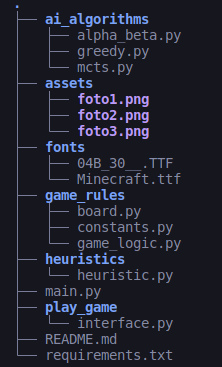


####  Armazenamento nos Diretórios
* **ai_algorithms:** códigos dos algoritmos de decisão propostos  
* **assets:** arquivos de imagem para o README.md  
* **fonts:** fontes usadas na interface gráfica  
* **game_rules:** códigos base do jogo, tais como validações, lógicas de jogo, constantes e tabuleiro  
* **heuristics:** códigos das heurísticas usadas pelos algoritmos de decisão  
* **play_game:** códigos da interface gráfica e loop do jogo

---

# **Estrutura do Jogo** (game_rules)

Antes de desenvolver os algoritmos criados, precisamos importar uma série de validações e regras lógicas que fazem o jogo funcionar.

In [1]:
import sys
import numpy as np
import math
import os
import time
import random
import itertools
from math import sqrt, log
from dataclasses import dataclass, field
from IPython.display import clear_output

### constants.py
As variáveis globais usadas durante toda a execuçãodo jogo são armazenadas em um arquivo constants.py.

In [2]:
HUMAN_PIECE = 1
AI_PIECE = 2

# Constants for the data matrix
ROWS = 6
COLUMNS = 7

### board.py
O estado do jogo é armazenado na classe abaixo, baiscamente é uma matriz 6x7 que se completa com valores 1 e 2, que são as peças dos jogadores

In [3]:
@dataclass
class Board:
    rows: int = ROWS
    columns: int = COLUMNS
    board: np.ndarray = field(default_factory=lambda: np.zeros((ROWS, COLUMNS)))
            
    def get_board(self) -> np.ndarray:
        return self.board

    def print_board(self) -> None:
        print(np.flip(self.board, 0), "\n")

### game_logic.py

In [4]:
def human_move(bd: Board, board: np.ndarray, turn: int, game_mode: int, interface: any) -> bool:
	"""Set the column of human move"""
	print("\nEscolha uma coluna de 1 a 7: ", end='')
	col = int(input()) -1
	while not 0 <= col < 7:
		print("Número de coluna inválida. Escolha novamente: ", end='')
		col = int(input()) -1
	if not is_valid(board, col): return False 
	make_move(bd, board, turn, col, game_mode, interface)
	return True

def make_move(bd: Board, board: np.ndarray, turn: int, move: int, game_mode: int, interface: any) -> bool:
    """Make the move and see if the move is a winning one"""
    row = get_next_open_row(board, move)
    drop_piece(board, row, move, turn)   
    clear_output(wait=True)
    interface.print_game_modes(game_mode)
    display(bd.print_board())
    return winning_move(board, turn) or is_game_tied(board)

def ai_move(bd: Board, game_mode: int, board: np.ndarray, turn: int, interface: any) -> int:
	"""Set the column of the AI move"""
	ai_column = get_ai_column(board, game_mode)
	game_over = make_move(bd, board, turn, ai_column, game_mode, interface)
	return game_over

def get_ai_column(board: Board, game_mode: int) -> int:
	"""Select the chose ai algorithm to make a move"""
	chosen_column = 0
	if game_mode == 2:
		chosen_column = a_star(board, AI_PIECE, HUMAN_PIECE)
	elif game_mode == 3:
		chosen_column = a_star_adversarial(board, AI_PIECE, HUMAN_PIECE)
	elif game_mode == 4:
		chosen_column = alpha_beta(board)
	elif game_mode == 5:
		chosen_column = mcts(board)
	return chosen_column

def simulate_move(board: np.ndarray, piece: int, col: int) -> None | np.ndarray:
	"""Simulate a move in a copy of the board"""
	board_copy = board.copy()
	row = get_next_open_row(board_copy, col)
	if row == None: return None
	drop_piece(board_copy, row, col, piece)
	return board_copy

def get_next_open_row(board: np.ndarray, col: int) -> int:
	"""Given a column, return the first row avaiable to set a piece"""
	for row in range(ROWS):
		if board[row][col] == 0:
			return row
	return -1

def available_moves(board: np.ndarray) -> list | int:
    """Return list of available columns to play"""
    available_moves = []
    for i in range(COLUMNS):
        if board[5][i] == 0:
            available_moves.append(i)
    return available_moves if len(available_moves) > 0 else -1


def drop_piece(board: np.ndarray, row: int, col: int, piece: int) -> None:
	"""Insert a piece into board on correct location"""
	board[row][col] = piece

def is_game_tied(board: np.ndarray) -> bool:
	"""Assert if the game is tied"""
	for i in range(len(board)):
		for j in range(len(board[0])):
			if board[i][j]==0: return False
	return True

def is_valid(board: np.ndarray, col: int) -> bool:
	"""Analize if chosen column is valid"""
	if not 0 <= col < COLUMNS: return False
	row = get_next_open_row(board, col)
	return 0 <= row <= 5

def winning_move(board: np.ndarray, piece: int) -> bool:
	"""Return if the selected move will win the game"""
	def check_horizontal(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on horizontal lines"""
		for col in range(COLUMNS-3):
			for row in range(ROWS):
				if board[row][col] == piece and board[row][col+1] == piece and board[row][col+2] == piece and board[row][col+3] == piece:
					return True	

	def check_vertical(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on vertical lines"""
		for col in range(COLUMNS):
			for row in range(ROWS-3):
				if board[row][col] == piece and board[row+1][col] == piece and board[row+2][col] == piece and board[row+3][col] == piece:
					return True		

	def check_ascending_diagonal(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on ascending diagonal lines"""
		for col in range(COLUMNS-3):
			for row in range(ROWS-3):
				if board[row][col] == piece and board[row+1][col+1] == piece and board[row+2][col+2] == piece and board[row+3][col+3] == piece:
					return True	

	def check_descending_diagonal(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on descending diagonal lines"""
		for col in range(COLUMNS-3):
			for row in range(3, ROWS):
				if board[row][col] == piece and board[row-1][col+1] == piece and board[row-2][col+2] == piece and board[row-3][col+3] == piece:
					return True
				
	return check_vertical(board, piece) or check_horizontal(board, piece) or check_ascending_diagonal(board, piece) or check_descending_diagonal(board, piece)

---


# **Algoritmos** (ai_algorithms)


## **Heurística** (heuristics.py)

Para 3 dos 4 algoritmos (A*, A* Adversarial, Alpha-Beta), utilizamos a mesma heurística, que foi baseada num cálculo de pontos para cada estado do tabuleiro. Primeiramente, vamos entender como ela funciona.  

Dado um estado de jogo(matriz 6x7 com distribuição de peças), queremos avaliar a pontuação desse estado específico.  
A cada 4 espaços do tabuleiro são contadas as peças de cada jogador e atribui-se uma quantidade de pontos a esse segmento. No final do tabuleiro, somam-se as pontuações de cada segmento para calcular a pontução geral daquele estado.  



#### Funções 

Para isso, foram criadas duas funções auxiliares para avaliar o score the determinado estado (posições das peças):  

A função **calculate_board_score()** segmenta a matriz em segmentos de 4 espaços (verticalmente, horizontalmente e diagonalmente).
Logo após, o segmento é passado como argumento para a função **weights()**, que calcula um valor de pontos associado a esse bloco de acordo com o número de peças de cada jogador existem no segmento.  
Para cada segmento, utilizamos a seguinte heurística, sendo "Player 1" = jogador e "Player 2" = IA:  

- Existem peças do Player 1 e do Player 2 = **0 pontos**
- 1 peça do Player 2 = **1 ponto**
- 2 peças do Player 2 = **10 pontos**
- 3 peças do Player 2 = **50 pontos**
- 4 peças do Player 2 = **1000 pontos**
- 1 peça do Player 1 = **-1 ponto**
- 2 peças do Player 1 = **-10 pontos**
- 3 peças do Player 1 = **-50 pontos**
- 4 peças do Player 1 = **-2000 pontos**

In [5]:
def calculate_board_score(board: np.ndarray, piece: int, opponent_piece: int) -> int:
    score = 0

    # Check horizontal
    for col in range(COLUMNS - 3):
        for r in range(ROWS):
            segment = [board[r][col + i] for i in range(4)]
            score += weights(segment, piece, opponent_piece)

    # Check vertical
    for col in range(COLUMNS):
        for r in range(ROWS - 3):
            segment = [board[r + i][col] for i in range(4)]
            score += weights(segment, piece, opponent_piece)

    # Check ascending diagonal
    for col in range(COLUMNS - 3):
        for r in range(ROWS - 3):
            segment = [board[r + i][col + i] for i in range(4)]
            score += weights(segment, piece, opponent_piece)

    # Check descending diagonal
    for col in range(COLUMNS - 3):
        for r in range(3, ROWS):
            segment = [board[r - i][col + i] for i in range(4)]
            score += weights(segment, piece, opponent_piece)

    return score

In [6]:
def weights(segment: list, piece: int, opponent_piece: int) -> int:
    if piece in segment and opponent_piece in segment: return 0
    if segment.count(piece) == 1: return 1
    if segment.count(piece) == 2: return 10
    if segment.count(piece) == 3: return 50
    if segment.count(piece) == 4: return 1000
    if segment.count(opponent_piece) == 1: return -1
    if segment.count(opponent_piece) == 2: return -10
    if segment.count(opponent_piece) == 3: return -50
    if segment.count(opponent_piece) == 4: return -2000
    return 0

Essa pontuação tenta simular um cálculo de probabilidade de vitória com uma certa jogada. Quanto mais perto de completar uma sequência de 4 peças, maior a pontuação. De forma análoga, quanto mais perto estiver o jogador oponente de uma sequência de 4 peças, mais negativo será a pontuação (pois queremos evitar a vitória do oponente). Quando há peças dos dois jogadores num segmento, esse espaço não pode mais representar uma possibilidade de viória para nenhum dos dois jogadores, logo, recebe uma pontuação nula.  

As pontuações são simétricas, exceto quando se tem as 4 posições preenchidas com peças do mesmo jogador, onde a pontuação de 4 peças inimigas equivale ao dobro (negativo) da pontuação de 4 peças aliadas. Isso acontece para que evitar a vitória do inimigo seja sempre a prioridade, em vez de preferir acumular pontos.  

Nota-se também que a pontuação é calculada com apenas uma procura na tabela. Inicialmente, havíamos tentando fazer uma varredura pela matriz em busca de cada uma das pontuações especificamente, o que gerava uma repetição desnecessária da procura. O modelo atual de implementação é um método mais eficiente de percorrer a matriz.

### Exemplo de utilização:

Dado o estado do tabuleiro abaixo criado, realizamos uma chamada à função calculate_board_state(), para avaliar a pontuação desse estado específico.

In [7]:
estado1 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 2, 0, 0, 0, 0, 0],
          [0, 2, 2, 2, 0, 0, 0],
          [0, 1, 1, 2, 1, 0, 0],
          [1, 1, 2, 1, 1, 1, 2]]


estado2 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 2, 0, 0, 0, 0, 0],
          [0, 2, 2, 2, 1, 0, 0],
          [2, 1, 1, 2, 1, 0, 2],
          [1, 1, 2, 1, 1, 1, 2]]


In [8]:
print("Score do estado 1: ", calculate_board_score(estado1, AI_PIECE, HUMAN_PIECE))
print("Score do estado 2: ", calculate_board_score(estado2, AI_PIECE, HUMAN_PIECE))

Score do estado 1:  181
Score do estado 2:  78


---

Agora que já podemos calcular as pontuções atríbuidas para cada estado, é necessário desenvolver algoritmos para escolher a melhor jogada.  

## **A\*** (a_star.py)

O algoritmo A* é um método de decisão que escolhe a melhor coluna para uma jogada, baseando-se apenas na melhor pontuação das 7 possibilidades existentes imediatamente após o estado atual.  

Para a sua implementação, criamos uma cópia do estado atual, realizamos uma jogada em cada coluna disponível e comparamos as pontuações obtidas com cada uma delas. A jogada que retornar a melhor pontuação será a escolhida. Simples assim.

In [35]:
def a_star(board: np.ndarray, ai_piece: int, opponent_piece: int) -> int:
    """Return the best column chose by A* algorithm"""
    start_time = time.time()
    best_score = float('-inf')
    best_move = -1
    for col in range(COLUMNS):
        if not is_valid(board, col): continue
        cur_score = 0
        simulated_board = simulate_move(board, ai_piece, col)
        cur_score = calculate_board_score(simulated_board, ai_piece, opponent_piece)
        if cur_score > best_score:
            best_move = col
            best_score = cur_score
    end_time = time.time()
    print(f"Tempo de resposta = {end_time-start_time}")
    return best_move


### Exemplo de utilização:

Abaixo, utilizaremos o mesmo estado mostrado antes. O próximo jogador a jogar é o Player 2, que será controlado pelo A*. Logo, a coluna 5 é a melhor jogada, pois ele completaria uma linha horizontal com 4 peças, ganhando o jogo. Veremos como o algoritmo calcula a melhor jogada.

In [36]:
estado3 = np.ndarray(shape=(6, 7), dtype=int, buffer=np.array([[1, 1, 2, 1, 1, 1, 2],
                                                              [0, 1, 1, 2, 1, 1, 0],
                                                              [0, 2, 2, 2, 0, 0, 0],
                                                              [0, 2, 0, 0, 0, 0, 0],
                                                              [0, 0, 0, 0, 0, 0, 0],
                                                              [0, 0, 0, 0, 0, 0, 0]]))


print("Melhor jogada no estado 3 para o player 2: coluna", a_star(estado3, AI_PIECE, HUMAN_PIECE)+1)

Tempo de resposta = 0.001863718032836914
Melhor jogada no estado 3 para o player 2: coluna 5


Como vemos, o A* teve sucesso ao calcular a melhor jogada para a sua vitória. Porém, por não ser um algoritmo para jogos adversariais, ele não consegue evitar a vitória do oponente.  

Embora tenhamos atribuído uma maior pontuação para sequências de 4 peças inimigas em relação á 4 peças aliadas, isso não é útil para o A*, uma vez que ele não consegue fazer previsões de jogadas do oponente. Esse algoritmo joga apenas procurando a sua própria vitória, independente do inimigo. Assim, só prejudica o jogo do outro jogador quando é para se beneficiar, mas não com o objetivo de evitar sua vitória inimiga.  
Para corrigir essa falha, adaptamos o A* para que funcione como um jogo adversarial

---

## **A\* Adversarial** (a_star.py)

Nessa adaptação, o A* avalia qual seria a melhor opção de coluna por meio da simulação das duas jogadas seguintes ao estado atual. Primeiro ele simula o score the cada jogada, e para cada simulação, ele também simula a melhor jogada inimiga em cima de sua própria jogada. Assim, em vez de simular apenas a jogada imediatamente seguinte (como faz o A* original), ele consegue jogar para evitar que o inimigo tenha boas jogadas
. 
Além disso, podemos fazer algo divertido para interagir com o jogador: mostrar uma dica de jogada optimal para o oponente, visto que ela já é calculada durante a previsão de jogada da IA.

Com isso, resolvemos o problema do A* anterior, pois agora conseguimos jogar para evitar a vitória do oponente, caso ela fosse ocorrer logo na sua jogada seguinte. No entanto, ainda não conseguimos prever o jogo além das duas jogadas seguintes. Para isso, temos o MCTS e o AlphBeta, que conseguem prever um maior número de jogadas seguintes de forma mais eficiente.  

In [40]:
def a_star_adversarial(board: np.ndarray, ai_piece: int, opponent_piece: int) -> int:
    """Return the best column chose by predictive A* algorithm"""
    start_time = time.time()
    move_score = float('-inf')
    best_move = -1
    best_opponent = 0;
    for col in range(COLUMNS):
        if not is_valid(board, col): continue
        cur_score = 0
        simulated_board = simulate_move(board, ai_piece, col)
        opponent_col = a_star(simulated_board, opponent_piece, ai_piece)  
        opponent_simulated_board = simulate_move(simulated_board, opponent_piece, opponent_col)
        cur_score = calculate_board_score(opponent_simulated_board, ai_piece, opponent_piece)
        if cur_score > move_score:
            best_opponent = opponent_col + 1
            best_move = col
            move_score = cur_score
    end_time = time.time()
    print(f"Tempo de resposta = {end_time-start_time}")
    print("Próximo passo sugerido para o oponente: coluna " + str(best_opponent+1))
    return best_move

### Exemplo de utilização:


In [41]:
estado4 = np.ndarray(shape=(6, 7), dtype=int, buffer=np.array([[1, 1, 2, 1, 1, 1, 2],
                                                               [0, 1, 1, 2, 1, 1, 0],
                                                               [0, 2, 2, 2, 0, 0, 0],
                                                               [0, 2, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0]]))

In [42]:
print("Jogada escolhida para o Player 2:", a_star_adversarial(estado4, AI_PIECE, HUMAN_PIECE)+1)

Tempo de resposta = 0.005741596221923828
Tempo de resposta = 0.0025882720947265625
Tempo de resposta = 0.0025177001953125
Tempo de resposta = 0.003435850143432617
Tempo de resposta = 0.0029599666595458984
Tempo de resposta = 0.0035076141357421875
Tempo de resposta = 0.005184173583984375
Tempo de resposta = 0.03062152862548828
Próximo passo sugerido para o oponente: coluna 7
Jogada escolhida para o Player 2: 5


---

## **Alpha-Beta Pruning** (alpha_beta.py)

O algoritmo Alpha-Beta percorre uma árvore completa, em que cada um de seus nós representa um estado do tabuleiro. A cada nível, o nó escolhido para retornar a pontuação é o da melhor jogada possível para o jogador atual.  
Ou seja, ao calcular a melhor jogada no nível em que o oponente joga, é escolhido o nó com a pontuação mais negativa (que mais beneficia o oponente). Já no nível em que a IA joga, é escolhido o nó com maior pontuação. Ao final, escolhe-se qual das 7 possíveis jogadas da IA gera uma melhor pontuação a longo prazo, no decorrer do jogo.  
A base dessa descrição é a mesma do algoritmo MiniMax, mas o AlphaBeta possui uma eficiência maior, uma vez que descarta galhos da árvore que já são perceptivelmente desnecessários. Assim, optamos por implementar apenas o Alpha-Beta, e não o MiniMax.

#### Funcionamento
Para que o algoritmo Alpha-Beta possa escolher a melhor jogada possível, ele também se utiliza da heurística. Para que o algoritmo funcione, precisamos definir um limite, caso contrário, ele testaria todas as opções possíveis, o que ultrapassa os recursos computacionais disponíveis. Para isso, optamos pr limitar o algorítmo pela profundidade (variável depht_limit).

Com o limite escolhido, o Alpha-Beta percorre estados filhos até que encontre um estado em que o jogo termine, ou até atingir o limite de profundidade, e depois retorna o resultado da pontuação deste nó, atualizando os valores de mínimo e máximo. A partir daí, os nós pais alternam entre pegar a pontuação máxima onde as peças aliadas estão jogando e a pontuação mínima onde as peças inimigas estão jogando, aplicando cortes dos ramos com as atualizações de valores máximos e mínimos (alpha e beta). 

O nó raíz é o estado atual do jogo, que pega o maior score possível entre os filhos do nível 1, para maximizar as chances de vitória do jogador atual, no nível 2, simulamos a jogada do oponente supondo que ele escolha uma jogada que vai minimizar nosso score, e assim alternamos até o último nó alcançavel.


In [48]:
def alpha_beta(board: np.ndarray) -> int:
    """Return the best column chose by alpha_beta algorithm"""
    # start_time = time.time()
    children = get_children(board, AI_PIECE)
    depth_limit = 5
    best_move = -1
    best_score = float('-inf')
    for (child, col) in children:
        if winning_move(child, AI_PIECE): 
            best_move = col
            break
        score = calculate(child, 0, float('-inf'), float('+inf'), depth_limit, False)
        if score > best_score:
            best_score = score
            best_move = col
    # end_time = time.time()
    # print(f"Tempo de resposta = {end_time-start_time}")
    return best_move


def calculate(board: np.ndarray, depth: int, alpha: int, beta: int, depth_limit: int, maximizing: bool) -> int:
    """Return the accumulated score for this current move"""
    if depth == depth_limit or winning_move(board, 1) or winning_move(board, 2):
        return calculate_board_score(board, AI_PIECE, HUMAN_PIECE)
    
    if maximizing:
        maxEval = float('-inf')
        children = get_children(board, AI_PIECE)
        for (child, col) in children:
            eval = calculate(child, depth+1, alpha, beta, depth_limit, False)
            maxEval = max(maxEval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return maxEval
    
    else:
        minEval = float('+inf')
        children = get_children(board, HUMAN_PIECE)
        for (child, col) in children:
            eval = calculate(child, depth+1, alpha, beta, depth_limit, True)
            minEval = min(minEval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return minEval


def get_children(board: np.ndarray, piece: int):
    """Return children of the actual state board"""
    children = []
    if available_moves(board) == -1: return  
    for col in available_moves(board):  
        copy_board = simulate_move(board, piece, col)   
        children.append((copy_board, col)) 
    return children

### Exemplo de utilização:

Nessa implementação, fizemos uma pequena modificação no algoritmo Alpha Beta original: fazemos uma checagem inicial de vitória (entre as opções diretas de jogadas da IA). Com isso, o comportamento do algoritmo se aproxima mais do comportamento de um humano: se uma jogada gerar uma vitória, não checa mais nenhuma possibilidade e já seleciona aquela como a melhor jogada.
Assim, em tabuleiros em que há uma vitória iminente da IA (como a seguir), o tempo de execução do algoritmo é muito menor.

In [43]:
estado5 = np.ndarray(shape=(6, 7), dtype=int, buffer=np.array([[1, 1, 2, 1, 1, 1, 2],
                                                               [0, 1, 1, 2, 1, 1, 0],
                                                               [0, 2, 2, 2, 0, 0, 0],
                                                               [0, 2, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0]]))

print("Melhor jogada board4 para o jogador 2:", alpha_beta(estado5)+1)

Tempo de resposta = 0.7150602340698242
Melhor jogada board4 para o jogador 2: 5


---

## **Monte Carlo Tree Search** (mcts.py)



*Classe **Node**:* Representa um nó na árvore de busca do MCTS. Cada nó tem as seguintes informações:
1. O estado atual do tabuleiro do jogo
1. O nó pai, contendo informações como o estado anterior do tabuleiro
2. Os nós filhos, contendo informações como os possíveis movimentos para se jogar e criar um novo tabuleiro.
3. O número de visitas deste nó (vezes que já foi explorado)
4. O número de vitórias deste nó (quantidade de vezes que esse nó leva à vitória nas simulações)
5. O jogador atual do estado.
  
A função **ucb()** calcula a UCB (Upper Confidence Bound) para balancear a exploração e a exploração durante a seleção de movimentos, a função **add_children()** adiciona possíveis movimentos (nós filhos) ao nó, e **score()** retorna o valor da pontuação de um nó,calculado a partir das suas visitas e vitórias.

*Classe **MCTS**:* Controla a busca MCTS a partir de um nó raiz. A função search executa a busca dentro de um limite de tempo. Durante a busca, são realizadas quatro etapas principais: seleção, expansão, simulação (rollout) e backpropagate.

1. *Seleção:* A função select() escolhe um nó da árvore para expandir, priorizando aqueles com maior UCB.
2. *Expansão:* A função expand() adiciona novos nós (possíveis movimentos) à árvore.
3. *Simulação (Rollout):* A função rollout() realiza simulações aleatórias do jogo até atingir um estado final de vitória ou empate.
4. *Backpropagate:* A função back_propagation() adiciona +1 às visitas de cada nó, e caso o jogador atual de cada nó for o mesmo que ganhou na simulação em rollout, adiciona também +1 nas vitórias.

*Função **mcts**:* Esta é a função de interface que inicializa a busca MCTS a partir do nó raiz e retorna a melhor coluna para o próximo movimento da AI.

In [44]:
@dataclass
class Node:
    def __init__(self, board, last_player, parent=None) -> None:
        self.board = board
        self.parent = parent
        self.children = []
        self.visits = 0
        self.wins = 0  
        self.current_player = 1 if last_player == 2 else 2

    def add_children(self) -> None:
        """Add each possible move to a list of possible children for the current node/state"""
        if available_moves(self.board) == -1: return   # Se não houver jogadas possíveis, não adiciona nós filhos
        for col in available_moves(self.board):  
            # Nós filhos: Cópias do tabuleiro atual com uma jogada possível a mais
            if self.current_player == HUMAN_PIECE:  copy_board = simulate_move(self.board, AI_PIECE, col)
            else: copy_board = simulate_move(self.board, HUMAN_PIECE, col)    
            self.children.append((Node(board=copy_board, last_player=self.current_player, parent=self), col)) 

    def __str__(self) -> str:
        string = "Estado: " + str(type(self.board)) + '\n'
        string += "Pai: " + str(self.parent != None) + '\n'
        string += "Nós Visitados: " + str(len(self.children)) + '\n'
        string += "Vitórias: " + str(self.wins) + '\n'
        string += "Total: " + str(self.visits) + '\n'
        string += "Pontuação: " + str(self.ucb()) + '\n'
        string += "Probabilidade de vitória: " + str(self.score()) + '\n'
        return string
    
    def ucb(self) -> float:
        """Calculate the Upper Confidence Bound of the node"""
        if self.visits == 0: return float('inf')
        exploitation = self.wins / self.visits
        exploration = sqrt(2) * sqrt(2 * log(self.parent.visits / self.visits, math.e)) if self.parent else 0
        return exploitation + exploration
    
    def score(self) -> float:
        """Calculate the score of the node"""
        if self.visits == 0: return 0
        return self.wins / self.visits


In [45]:
@dataclass
class MCTS:
    def __init__(self, root: Node) -> None:
        self.root = root

    def search(self, max_time: int) -> int:
        """Iterate through the tree of possible plays"""
        start_time = time.time()
        while time.time() - start_time < max_time:                # Limite das iterações: tempo em segundos
            selected_node = self.select(self.root)                # Etapa Select: seleciona um filho pelo valor UCB
            result = selected_node.current_player                 # Olha se o jogo ainda está em aberto
            if not winning_move(selected_node.board, AI_PIECE):   # Confirma se o nó selecionado já é um estado terminal
                expanded_child = self.expand(selected_node)       # Etapa expansão: adiciona os filhos e seleciona um  
                result = self.rollout(expanded_child)             # Etapa simulação: simula um jogo até o fim e retorna vencedor ou empate
            self.back_propagation(selected_node, result)          # Etapa backpropagation: atualiza os status dos nós após a simulação
        return self.best_move()                                   # Retorna a coluna correspondente ao melhor nó filho do root

    def select(self, node: Node) ->  Node:
        """Select node to be expanded"""
        if len(node.children) > 0: node = self.best_child(node)   # Retorna o melhor filho usando o UCB, ou ele mesmo caso não tenha filhos
        return node
    
    def best_child(self, node: Node) -> Node:
        """Select the best child to be expanded based on their ucb's"""
        best_child = None
        best_score = float('-inf')
        for tuplo in node.children:
            child = tuplo[0]
            ucb = child.ucb() if child.visits != 0 else float("+inf")
            if ucb > best_score:
                best_child = child
                best_score = ucb
        return best_child

    def back_propagation(self, node: Node, result: int) -> None:
        """Go through the tree to update the score of each node above the current one"""
        while node:                                                
            node.visits += 1                       # Adiciona visitas
            if node.current_player == result:                      
                node.wins += 1                       # Adiciona vitórias caso o jogador do nó seja igual ao vencedor da simulação
            node = node.parent                     # Itera do nó filho até o root
    
    def expand(self, node: Node) -> Node:
        """Expand the node, by adding its children to the tree, and select one random child to be expanded"""
        node.add_children()
        return random.choice(node.children)[0]     
       
    def rollout(self, node: Node) -> int:
        """Simulate a entire play until someone wins or game draw"""
        board = node.board.copy()                           
        players = itertools.cycle([AI_PIECE, HUMAN_PIECE])     # Cria uma iteração sobre os jogadores de cada nível
        current_player = next(players)
        while not (winning_move(board, AI_PIECE) or winning_move(board, HUMAN_PIECE)):   # Continua a simulação até o jogo simulado acabar
            current_player = next(players)
            values = available_moves(board)                    # Seleciona colunas possíveis de se jogar
            if values == -1:                                   # se não houver mais colunas disponíveis e o jogo não acabou, retorna empate (0)
                current_player = 0
                break
            col = random.choice(values)                        # escolhe aleatoriamente uma das possibilidades de jogada
            board = simulate_move(board, current_player, col)  # simula a jogada escolhida
        return current_player                                  # Retorna o jogador vencedor ou empate(0)
    
    def best_move(self) -> int:
        """Select the best column to be played based on children scores"""
        max_uct = float('-inf')
        scores = {}    # armazenas todas as colunas e seus scores
        columns = []   # armazena as colunas que têm score = melhor score
        for (child, col) in self.root.children:   
            uct = child.score()     
            if uct > max_uct:        
                max_uct = uct        
            scores[col] = uct        
        for col, score in scores.items(): 
            if score == max_uct:
                columns.append(col)    
        return random.choice(columns)    # Escolhe uma jogada random dentre as melhores jogadas
            
def mcts(board: np.ndarray) -> int:
    """Should return the best column option, chose by mcts algorithm"""
    root = Node(board=board, last_player=AI_PIECE)
    mcts = MCTS(root)
    column = mcts.search(5)             # Argumento = tempo em segundos
    return column

### Exemplo de utilização:

In [46]:
estado6 = np.ndarray(shape=(6, 7), dtype=int, buffer=np.array([[1, 1, 2, 1, 1, 1, 2],
                                                               [0, 1, 1, 2, 1, 1, 0],
                                                               [0, 2, 2, 2, 0, 0, 0],
                                                               [0, 2, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0],
                                                               [0, 0, 0, 0, 0, 0, 0]]))

print("Melhor jogada board4 para o jogador 2:", mcts(estado6)+1)

Melhor jogada board4 para o jogador 2: 5


---


# **Jogando** (play_game)

## interface.py
Aqui ficam armazenadas as funções relacionadas à interface do jogo e a execução do jogo dentro de um loop while que se repete até algum jogador ganhar ou o jogo der empate. Para criar a interface, utilizamos a biblioteca pygame. As funções de lógica do jogo estão bem integradas com o pygame, mas optamos por retirar toda a parte da interface para que fosse possível testar os algorítmos. No código original é mais complexo.

In [18]:
@dataclass
class Interface:
    rows: int = ROWS
    columns: int = COLUMNS

    def print_game_modes(self, value: int) -> None:
        game_modes = {1: 'Human x Human',
                      2: 'A*',
                      3: 'Predictive A*',
                      4: 'AlphaBeta',
                      5: 'MCTS'}
        print(f"Modo de jogo escolhido: {game_modes[value]}\n")

    def start_game(self, bd: Board) -> None:
        """Set up the conditions to the game, as choose game_mode and draw the pygame display"""
        game_mode = int(input("Selecione um modo de jogo:\n 1- A*\n 2- Predictive A*\n 3- AlphaBeta\n 4- MCTS\n")) +1
        # os.system('clear')
        clear_output(wait=True)
        self.print_game_modes(game_mode)
        bd.print_board()
        self.play_game(bd, game_mode)
        
    def play_game(self, bd: Board, game_mode: int) -> None:
        """Run the game"""
        board = bd.get_board()	
        game_over = False
        turns = itertools.cycle([1, 2])  
        turn = next(turns)

        while not game_over:
            if turn == 1 or (turn == 2 and game_mode == 1):  # get human move
                if not human_move(bd, board, turn, game_mode, self): continue  # make a move
                if winning_move(board, turn): 
                    game_over = True
                    break
                turn = next(turns)
            elif turn != 1 and game_mode != 1: 
                time.sleep(0.2)
                game_over = ai_move(bd, game_mode, board, turn, self)
                if game_over: break     
                turn = next(turns)
            # Evita que a ultima jogada no ultimo ponto possível retorne empate ao invès de vitória
            if is_game_tied(board) and game_over == False:
                print(f"Empate!")
                break   
        if not is_game_tied(board):
            print(f"Player {turn} venceu o jogo!")

## main.py
Para executar o jogo, basta digitar python3 main.py. Isso acionará o método main() e instanciará um objeto Board, um objeto Interface e chamara a função para rodar o jogo(Interface.start_game())





In [19]:
def main() -> None:
    board = Board()
    interface = Interface()
    interface.start_game(board)
    
if __name__ == "__main__":
    main()

Modo de jogo escolhido: AlphaBeta

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 2. 1. 0. 0.]
 [0. 0. 2. 1. 2. 0. 0.]
 [0. 2. 1. 2. 1. 0. 0.]
 [1. 2. 1. 1. 1. 2. 0.]] 



None

Player 2 venceu o jogo!


---

# **Análises para Escolhas**

Durante a implementação, precisamos escolher uma boa heurística e uma boa constante de equilíbrio entre Exploitation e Exploration para o MCTS.  
Para isso, rodamos alguns testes para entendermos melhor a performance de cada um.

### Heurística

Para a heurística, consideramos 3 opções:

1. HEURITÍCA 1: Score de uma sequência de 4 peças do oponente é 2 vezes maior que uma sequência de 4 peças do próprio jogador
- Existem peças do Player 1 e do Player 2 = **0 pontos**
- 1 peça do Player 2 = **1 ponto**
- 2 peças do Player 2 = **10 pontos**
- 3 peças do Player 2 = **50 pontos**
- 4 peças do Player 2 = **1000 pontos**
- 1 peça do Player 1 = **-1 ponto**
- 2 peças do Player 1 = **-10 pontos**
- 3 peças do Player 1 = **-50 pontos**
- 4 peças do Player 1 = **-2000 pontos**

2. HEURÍSTICA 2: Score de uma sequência de 4 peças do jogador é 2 vezes maior que uma sequência de 4 peças do oponente:
- Existem peças do Player 1 e do Player 2 = **0 pontos**
- 1 peça do Player 2 = **1 ponto**
- 2 peças do Player 2 = **10 pontos**
- 3 peças do Player 2 = **50 pontos**
- 4 peças do Player 2 = **2000 pontos**
- 1 peça do Player 1 = **-1 ponto**
- 2 peças do Player 1 = **-10 pontos**
- 3 peças do Player 1 = **-50 pontos**
- 4 peças do Player 1 = **-1000 pontos**

3. HEURÍSTICA 3: Todos os scores do oponente são dobrados:
- Existem peças do Player 1 e do Player 2 = **0 pontos**
- 1 peça do Player 2 = **1 ponto**
- 2 peças do Player 2 = **10 pontos**
- 3 peças do Player 2 = **50 pontos**
- 4 peças do Player 2 = **1000 pontos**
- 1 peça do Player 1 = **-2 ponto**
- 2 peças do Player 1 = **-20 pontos**
- 3 peças do Player 1 = **-100 pontos**
- 4 peças do Player 1 = **-2000 pontos**

---

# **Análise dos Algoritmos**

Nessa etapa, efetuamos diversos testes para analisar como cada algoritmo funciona para diferentes casos.  
Utilizamos exemplos reais de estados, simulamos com a jogada da IA e analisamos o porquê de determinada coluna de jogada ter sido escolhida.

**Informações da análise**  
**Peças 1** = Movimentos feitos pelo humano  
**Peças 2** = Movimentos feitos pela IA  
**Estado_inicial** = Tabuleiro após a jogada humana  
**Estado_seguinte** = Tabuleiro após jogada da IA

## Análise do AlphaBeta:
Normalmente, o AlphaBeta com 4 níveis de profundidade é o suficiente para ganhar de um humano comum. Observa-se o número médio de nós percorridos é bem maior do que quando utilizamos uma profundidade de 3, e bem menor que uma profundidade de 5. Isso se deve à natureza do AlphaBeta, de ser um grafo em forma de àrvore. O tempo de execução é correlacionado com o número de nós percorridos. A capacidade de decisão de uma profundidade de 4 é bem maior que uma profundidade de 3, porém, em compensação, aumenta-se o tempo de execução.

Ou seja, quanto maior o limite, melhor e mais demorada fica a resposta. 



### Código utilizado:
Na função principal do AlphaBeta, medimos o tempo de execução com a biblioteca time, e os nós percorridos com uma variável global que recebe +1 em cada visita da função calculate() a um nó.


  #### Analise 1: Início do jogo

Resultado esperado: No estado_inicial, é lógico que as colunas do meio possuem mais maneiras de formar segmentos de 4 peças e ganhar o jogo. Queremos que o AlphaBeta jogue na coluna 4.

Resultado obtido: 

Resultado esperado igual ao resultado obtido. O AlphaBeta conseguiu visualizar o que queriamos e jogou no meio através de uma avaliação com scores da heurística.
A partir da profundidade 3, o número de nós efetivamente percorridos já passa a ser muito menor do que o número de nós existentes na árvore com tal profundidade, devido ao prunning das branches que não nos interessam.

#### Analise 2: Movimento do AlphaBeta para ganhar

Resultado esperado: No estado_inicial, o AlphaBeta tem a possibilidade de ganhar o jogo na coluna 2 com uma linha vertical de 4 peças. Queremos que ele jogue na coluna 2.

Resultado obtido:

Resultado esperado igual ao resultado obtido. AlphaBeta jogou na coluna 2 e ganhou o jogo.  
Como foi adicionada uma checagem de possíveis vitórias imediatas, a execução é interrompida ao checar a jogada na coluna 2. Então o score das colunas seguintes não é calculado.

#### Analise 3: Movimento do AlphaBeta para impedir o oponente de ganhar

Resultado esperado: No estado_inicial, nós do grupo, podemos ganhar o jogo caso joguemos na coluna 2 na próxima rodada. Queremos que ele nos impeça de ganhar na coluna 2.

Resultado obtido:

Resultado esperado igual ao resultado obtido. O AlphaBeta conseguiu ver a possibilidade e nos impediu, como esperado. O número de nós foi menor que o normal (em comparação, por exemplo, com a jogada inicial mostrada acima), assim como o tempo de resposta, devido ao fato do valor de score máximo estar na segunda coluna. Assim, os prunes puderam ser feitos nas colunas subsequentes.

#### Analise 4: Situação de vitória ou derrota

Resultado esperado: No estado_inicial, o AlphaBeta está numa situação de que ele tem que escolher entre ganhar se jogar na coluna 3, ou nos impedir de ganhar na próxima rodada jogando na coluna 2. Queremos que ele opte por ganhar, na coluna 3.

Resultado obtido:

Resultado esperado igual ao resultado obtido. Podemos perceber que a coluna 2 também é considerada uma boa jogada, pois tem uma pontuação positiva, mas a jogada para ganhar sempre será priorizada, inclusive interrompendo a busca por outras possibilidades. Assim, o tempo e os nós percorridos foram muito menores.

## Análise do MCTS:

Num geral, o MCTS com 3 segundos como limite já o é o suficiente para ganhar de humanos comuns, mas sofre um pouco com outros algorítmos adversáriais, como o AlphaBeta e o A* Adversarial. Para esse de teste, estamos jogando contra o MCTS com 3 e 6 segundos de limite e utilizando a constante = raiz de 2, para balanceamento entre Exploitation and Exploration.


**Vitórias:** Número de vitórias da IA que partiam desse nó  
**Total:** Número de jogos simulados com esse nó  
**Pontuação:** Pontuação UCB do nó  
**Probabilidade de vitória:** Vitórias / Visitas

### Código utilizado:

Adicionamos à classe *Node* a função *str* abaixo. Assim, ao fim da execução de uma rodada, printamos as seguintes informações sobre cada jogada possível a ser feita.  

### MCTS - 3 segundos:


  #### Analise 1: Início do jogo

Resultado esperado: No estado_inicial apresentado, é suposto que o MCTS tenda a jogar nas posições do meio devido à uma maior facilidade de gerar segmentos de 4 peças identicas em diversas posições. Nós, como jogadores, escolhemos a coluna com maior probabilidade de gerar combinações, a coluna 4.

Resultado obtido:

Resultado esperado igual ao resultado obtido. Baseado na probabilidade de vitória, o estado escolhido foi o 5, com a maior probabilidade de vitória = 0.31216, e está relacionado à coluna 5. Resultado dentro do esperado, pois jogou em colunas centrais.

#### Análise 2: Movimento do MCTS para ganhar

Resultado esperado: No estado_inicial, temos o jogo mais avançado e o MCTS tem uma possibilidade de ganhar caso jogue na coluna 3, fazendo uma diagonal de peças. Queremos que ele jogue na coluna 3.

Resultado obtido:

Resultado obtido igual ao esperado. Baseado na probabilidade de vitória, o estado escolhido foi o 3, com a maior probabilidade de vitória = 1.0, e está relacionado à coluna 3. O MCTS ganhou o jogo.


#### Análise 3: Movimento do MCTS para impedir o oponente de ganhar

Resultado esperado: No estado_inicia, nosso grupo tem a possibilidade de vencer o jogo na próxima rodada com uma diagonal, jogando na coluna 5. Queremos que o MCTS não permita isso e jogue na coluna 5.

Resultado obtido:

Resultado esperado igual ao resultado obtido. O MCTS escolheu a coluna 5 para evitar que ganhemos. O nó filho relacionado à coluna 5 retorna a maior probabilidade de vitória = 0.8443305573350416. 



#### Análise 4: Situação de vitória ou derrota

Resultado esperado: No estado_inicial, o MCTS tem 2 escolhas, ganhar o jogo nas colunas 3 ou 7, ou nos impedir de ganhar jogando na coluna 4. Queremos que ele jogue nas colunas 3 ou 7 para que ganhe.

Resultado obtido:

Resultado esperado igual ao resutlado obtido. O MCTS descobriu que as chances de vitória ao se jogar na coluna 3 e 7 são de 100%. Nota-se que a probabilidade de jogar na coluna 4 também é boa para ele, com probabilidade de vitória de 0.6713906111603188. O MCTS conseguiu ganhar nessa situação escolhendo a coluna 7.



### MCTS - 6 segundos:


  #### Analise 1: Início do jogo

Resultado esperado: No estado_inicial apresentado, é suposto que o MCTS tenda a jogar nas posições do meio devido à uma maior facilidade de gerar segmentos de 4 peças identicas em diversas posições. Nós, como jogadores, escolhemos a coluna com maior probabilidade de gerar combinações, a coluna 4. Queremos que ele jogue nas colunas centrais.

Resultado obtido:

Resultado esperado igual ao resultado obtido. O MCTS optou por jogar na coluna do meio, algo já esperado, visto que as coluna do meio é a que possui mais opções de combinações de segmentos de 4, e a que obteve mais vitórias nas simulações = 0.44983818770226536.


#### Análise 2: Movimento do MCTS para ganhar

Resultado esperado: No estado_inicial, o MCTS se encontra numa situação em que ele consegue ganhar caso jogue na coluna 3, realizando uma diagonal. Queremos que ele jogue na coluna 3.

Resultado obtido:

Resultado obtido igual ao resultado esperado. O MCTS conseguiu ver a coluna 3 como possibilidade de vitória e ganhou o jogo. A coluna 3 possuia a maior probabilidade de vitória = 1.0.


#### Análise 3: Movimento do MCTS para impedir o oponente de ganhar

                  
Resultado esperado: No estado_inicial, apenas 6 filhos existem, pois a coluna 4 está cheia. Nosso grupo consgue ganhar o jogo ao jogar na coluna 2, tanto verticalmente como na diagonal. Queremos que o MCTS nos impeça e jogue na coluna 3.

Resultado obtido:


Resultado esperado igual ao resultado obtido. O MCTS conseguiu nos impedir jogando na coluna 2. A probabilidade do MCTS ganhar o jogo era maior caso ele nos impedisse na coluna 2. Probalidade de vitória = 0.9334382729930291.


#### Análise 4: Situação de vitória ou derrota

Resultado esperado: No estado_inicial, nosso grupo pode ganhar na próxima rodada jogando na coluna 6, e o MCTS pode ganhar na próxima jogada, jogando na coluna 1. Queremos que ele jogue na coluna 1 e ganhe, ao invés de nos impedir.

Resultado obtido:

Resultado esperado igual ao resultado obtido. O MCTS ganhou o jogo escolhendo a coluna 1 com probabilidade de vitória = 1.0. Vale notar que a probabilidade de jogar na coluna 6 foi de 0.9924312635156008, ou seja, caso nos impedisse de ganhar, a chance de ganhar o jogo ainda continuaria alta. Mas optou por ganhar de uma vez.
 

# MCTS x AlphaBeta

2. MCTS vs adversarial (estudar o quanto a porcentagem sobe de acordo com o tempo do MCTS)
3. Alpha Beta vs adversarial (estudar o quanto a porcentagem sobe de acordo com a profundidade do AB)
4. MCTS vs alpha beta (cada um com seu melhor empenho, comparar pra ver quem é melhor)


Num geral, o MCTS com 3 segundos como limite já o é o suficiente para ganhar de humanos comuns, mas sofre um pouco com outros algorítmos adversáriais, como o AlphaBeta e o A* Adversarial. Para efeitos de teste, colocamos o MCTS com 3 segundos de limite para jogar contra o A* Adversarial, que é o algoritmo que mais se aproxima do modo de jogo humano (raciocina 2 jogadas à frente), e o resultado foi que, de 20 jogos, o MCTS ganhou 10 jogos e empatou 3. Mas ao subir o tempo de 3 segundos para 7, ele conseguiu vencer 15 jogos e empatou 1.
